# Lecture, analyse et visualisation d'images radar à synthèse d'ouverture

Une série multi-temporelle d'images acquises sur la même zone vous sont mises à disposition. La valeur stockée dans chaque pixel est un nombre complexe *z*:
$$
z = a+jb = Ae^{j\phi}
$$
où $A$ représente l'amplitude et $\phi$ la phase. La phase d'une image étant uniformement distribuée, elle n'apporte pas d'information. On ne s'intéressera donc qu'à l'amplitude (on peut ici utiliser la fonction `numpy.abs`).

D'abord, on importe le fichier python *mvalab.py*, qui contient des fonctions qui permettent la lecture des images SAR.


In [ ]:
!wget https://perso.telecom-paristech.fr/dalsasso/TPSAR/mvalab.py

In [ ]:
import mvalab
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math  as mt
from skimage import color
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

In [ ]:
def visusar(image,threshold=None):
    if threshold == None:
      threshold = np.mean(image)+3*np.std(image)
    image = np.clip(image,0,threshold)
    image = image/threshold*255
    plt.figure(figsize=(12,12))
    plt.imshow(image,cmap='gray')
    plt.show()

In [ ]:
# 21 images capturées sur Paris par le satellite allemand TerraSAR-X entre 2009-01-24 and 2010-11-26 sont également disponibles
webpage='https://perso.telecom-paristech.fr/dalsasso/TPSAR/paris/'
image='PileiEiffeljavelRECALZ4RECSP.IMA'
im_slc_tsx_paris_liste=mvalab.imz2mat(webpage+image)
im_tsx_paris = im_slc_tsx_paris_liste[0]
im_abs_tsx_paris = np.abs(im_tsx_paris)

In [ ]:
m,n,k=im_abs_tsx_paris.shape # 21 images (dates), chacune de taille 2048x2048 pixels
m,n,k

In [ ]:
# si on affiche toute la dynamique, l'image apparaît peu contrastée et seulement quelques points ressortent (très forts rétrodiffuseurs)
plt.figure(figsize=(8,8))
plt.imshow((im_abs_tsx_paris[:,:,0]),cmap='gray')
plt.show()

In [ ]:
# on visualise la première (index 0) et la cinquème (index 4) date de la pile
visusar((im_abs_tsx_paris[:,:,0]))
visusar((im_abs_tsx_paris[:,:,4]))

Lorsq'on visualise plusieurs images de la même pile, il est important de les afficher avec la même dynamique. On peut donc estimer le seuil pour une image et l'imposer aux autres dates de la même série multitemporelle. Ici, on choisit comme référence la première date.

In [ ]:
seuil = np.mean(im_abs_tsx_paris[:,:,0])+3*np.std(im_abs_tsx_paris[:,:,0])
visusar(im_abs_tsx_paris[:,:,0],seuil)
visusar(im_abs_tsx_paris[:,:,4],seuil)

In [ ]:
import imageio
!mkdir img
seuil = np.mean(im_abs_tsx_paris[:,:,0])+3*np.std(im_abs_tsx_paris[:,:,0])
def create_frame(t):
    fig = plt.figure(figsize=(12, 12))
    image = np.clip(im_abs_tsx_paris[:,:,t],0,seuil)
    image = image/seuil*255
    plt.imshow(image,cmap='gray')
    plt.savefig(f'./img/img_{t}.png',
                transparent = False,
                facecolor = 'white'
               )
    plt.close()

for t in range(21):
    create_frame(t)
frames = []
for t in range(21):
    image = imageio.v2.imread(f'./img/img_{t}.png')
    frames.append(image)

imageio.mimsave('./serie.gif', # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second

In [ ]:
from IPython.display import Image
Image(open('./serie.gif','rb').read())

In [ ]:
#les dates considérées
dates_str = [
    'TSX-1_A_20090124', 'TSX-1_A_20090204', 'TSX-1_A_20090215', 'TSX-1_A_20090309', 'TSX-1_A_20090320',
    'TSX-1_A_20090411', 'TSX-1_A_20090422', 'TSX-1_A_20090503', 'TSX-1_A_20090514', 'TSX-1_A_20090525',
    'TSX-1_A_20100111', 'TSX-1_A_20100122', 'TSX-1_A_20100202', 'TSX-1_A_20100213', 'TSX-1_A_20100224',
    'TSX-1_A_20100307', 'TSX-1_A_20100409', 'TSX-1_A_20100603', 'TSX-1_A_20100614', 'TDX-1_A_20101115',
    'TSX-1_A_20101126'
]

t = np.array([datetime.strptime(date[8:], "%Y%m%d").toordinal() for date in dates_str])

##Etude de la statistique des Images

In [ ]:
# analyse de l'histogramme de l'amplitude d'une image (première date)
from scipy.stats import rayleigh
plt.figure()
plt.hist(im_abs_tsx_paris[:,:,0].ravel(),bins='auto',density=True,range=[0.,1500], label = "histogramme de l'image")
plt.title("histogramme  d'amplitude")
x = np.linspace(0,1500,1500)

hist, bin_edges = np.histogram(im_abs_tsx_paris[:,:,0].ravel(), bins='auto',density = True)
m = bin_edges[np.argmax(hist)]
plt.axvline(m, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(m, max_ylim * 0.9, 'Mode: {:.2f}'.format(m))
rayleigh_pdf = rayleigh(scale =m).pdf(x)
plt.plot(rayleigh_pdf, label='distribution de Rayleigh')
plt.legend()
plt.show()

In [ ]:
# analyse de l'histogramme de l'inrensité d'une image (première date)
plt.figure()
plt.hist((im_abs_tsx_paris[:,:,0]**2).ravel(),bins='auto',density=True,range=[0.,100000], label = "histogramme de l'image")
plt.title("histogramme  d'intensité")
plt.show()

In [ ]:
(m,n,k) = im_abs_tsx_paris.shape
eps = 1e-16
img = np.zeros((m,n,k))
m_gamma = np.zeros(k-1)
for i in range (1,k):
  img[:,:,i] =np.std(im_abs_tsx_paris[:,:,:i+1], axis = 2)/(np.mean(im_abs_tsx_paris[:,:,:i+1], axis = 2) + eps)
  m_gamma[i-1] = np.mean(img[:,:,i])

In [ ]:
mx = np.max(img[:,:,k-1])
plt.hist(img[:,:,k-1].ravel(),bins='auto',density=True,range=[0.,mx])
plt.axvline(img[:,:,k-1].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.title("Histogramme du coefficient de variation")
plt.text(img[:,:,k-1].mean()*1.1, max_ylim*0.9, 'Mean: {:.4f}'.format(img[:,:,k-1].mean()))

plt.legend()

In [ ]:
plt.plot(np.arange(2,k+1),m_gamma)

In [ ]:
A = im_abs_tsx_paris
m1 = np.mean(A, axis = 2)
m2 = np.mean(A**2, axis = 2)
m3 = np.mean(A**3,  axis = 2)
m4 = np.mean(A**4, axis = 2)
v = 0.25 * (4 * m2**3 - m2**2 *m1**2 + m1**2 *m4 - 4 * m1*m2*m3)/(m1**4*(m2-m1**2))
vx = np.max(v)
plt.hist(v.ravel(),bins='auto',density=True,range=[0,1])
plt.axvline(v.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(v.mean(), max_ylim*0.9, 'Mean: {:.4f}'.format(v.mean()))

# histv, bin_edgesv = np.histogram(v.ravel(), bins='auto',density = True)
# mv = bin_edgesv[np.argmax(histv)]
# plt.axvline(mv, color='k', linestyle='dashed', linewidth=1)
# min_ylim, max_ylim = plt.ylim()
# plt.text(mv, max_ylim * 0.8, 'Mode: {:.2f}'.format(mv))

plt.title("Histogramme de N x la variance du coefficient de variation")

In [ ]:
image_moy = np.mean(im_abs_tsx_paris, axis = 2)

In [ ]:
(m,n,k) = im_abs_tsx_paris.shape
d = 64
n1 = n//d
m1 = m//d
pas  = 8
L = []
i0,j0 = 0,0
min_L = 1e6
window = np.zeros((m1,n1))
for i in range(0,m-m1,2*pas):
  for j in range (0,n-n1,2*pas):
      window = image_moy[i:i+m1,j:j+n1]
      s = np.std(window)
      if(s < min_L):
        min_L = s;
        i0 = i;
        j0 = j;
      L.append(s)
plt.plot(L)

In [ ]:
(np.argmin(L),np.min(L))

In [ ]:
(i0,j0)

In [ ]:
seuil = np.mean(im_abs_tsx_paris[:,:,0])+3*np.std(im_abs_tsx_paris[:,:,0])
image = np.clip(im_abs_tsx_paris[:,:,k-1],0,seuil)
image = image/seuil
image_col = np.zeros((m,n,3))
image_col[:,:,0] = image
image_col[:,:,1] = image
image_col[:,:,2] = image
image_col[i0:i0+ m1, j0: j0 + n1,0] = 1
image_col[i0:i0+ m1, j0: j0 + n1,1] = 0
image_col[i0:i0+ m1, j0: j0 + n1,2] = 0

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(image_col)

In [ ]:
plt.figure()
plt.hist(im_abs_tsx_paris[i0:i0+ m1, j0: j0 + n1,0].ravel(),bins='auto',density=True,range=[0.,300], label = "histogramme d'une zone homogène")
plt.title("histogramme d'amplitude")
x = np.linspace(0,300,300)

hist, bin_edges = np.histogram(im_abs_tsx_paris[i0:i0+ m1, j0: j0 + n1,0].ravel(), bins='auto',density = True)
m = bin_edges[np.argmax(hist)]
plt.axvline(m, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(m, max_ylim * 0.9, 'Mode: {:.2f}'.format(m))
rayleigh_pdf = rayleigh(scale = m).pdf(x)
plt.plot(rayleigh_pdf, label='distribution de Rayleigh')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.hist((im_abs_tsx_paris[i0:i0+ m1, j0: j0 + n1,0]**2).ravel(),bins='auto',density=True,range=[0.,20000], label = "histogramme d'une zone homogène")
plt.title("histogramme d'intensité")

plt.show()

In [ ]:
img_stable = img[i0:i0+ m1, j0: j0 + n1,:]
m_gamma_stable = np.zeros(k-1)
std_gamma_stable = np.zeros(k-1)
for i in range (1,k):
  m_gamma_stable[i-1] = np.mean(img_stable[:,:,i])

In [ ]:
plt.plot(np.arange(2,k+1),m_gamma_stable)

In [ ]:
m_gamma_stable[k-2]

In [ ]:
A = img_stable
m1 = np.mean(A, axis = 2)
m2 = np.mean(A**2, axis = 2)
m3 = np.mean(A**3,  axis = 2)
m4 = np.mean(A**4, axis = 2)
v = 0.25 * (4 * m2**3 - m2**2 *m1**2 + m1**2 *m4 - 4 * m1*m2*m3)/(m1**4*(m2-m1**2))
np.mean(v)


###**Débruitage temporel**

On a fixé la taille de la fenêtre mobile à 3.

On remarque que si on augmente la taille de la fenêtre, la qualité de l'image s'améliore, mais on détecte moins les changements rapides.

In [ ]:
#débruitage temporel
def temporal_denoising(img, window_size = 3):
  m,n,k=img.shape

  x_image = img.real
  y_image = img.imag

  x_debruite = np.zeros_like(img)
  y_debruite = np.zeros_like(img)
  for i in range(k):
      start_idx = max(0, i - window_size // 2)
      end_idx = min(k, i + window_size // 2 + 1)
      xwindow = x_image[:, :, start_idx:end_idx]
      ywindow = y_image[:, :, start_idx:end_idx]
      x_debruite[:, :, i] = np.mean(xwindow, axis=2)
      y_debruite[:, :, i] = np.mean(ywindow, axis=2)
  return (x_debruite + 1j *y_debruite)

In [ ]:
debruitees = np.abs(temporal_denoising(im_slc_tsx_paris_liste[0]))

In [ ]:
visusar(debruitees[:,:,0])

###**Debruitage spatial**
Dans cette partie, nous allons considérer une portion de l'image d'indice 0

In [ ]:
x_start, x_end = 1150, 1550   # Région en X
y_start, y_end = 1000, 1400   # Région en Y

In [ ]:
import matplotlib.patches as patches
def visusar1(image,x_start = x_start, x_end = x_end, y_start = y_start, y_end = y_end, threshold=None):
    if threshold is None:
        threshold = np.mean(image) + 3 * np.std(image)
    image = np.clip(image, 0, threshold)
    image = image / threshold * 255
    plt.figure(figsize=(12, 12))
    plt.imshow(image, cmap='gray')
    roi_rectangle = patches.Rectangle((y_start, x_start), y_end - y_start, x_end - x_start,
                                      linewidth=2, edgecolor='r', facecolor='none')
    # Ajouter le rectangle à l'image
    plt.gca().add_patch(roi_rectangle)

    plt.show()

In [ ]:
image0 = im_abs_tsx_paris[:, :, 0]
visusar1(image0)

In [ ]:
imc = im_tsx_paris[x_start:x_end, y_start:y_end,0]

In [ ]:
im_abs = image0[x_start:x_end, y_start:y_end]
# Afficher l'image zoomée
visusar(im_abs)

In [ ]:
np.std(im_abs**2)

In [ ]:
from scipy import ndimage
def sub_visusar(image,filter,threshold=None):
  l = [3,5,7]
  fig,ax = plt.subplots(1,3, figsize = (15,15))
  for i in range (3):
    imdeb = filter(img = image, window_size = l[i])
    if threshold == None:
      threshold = np.mean(imdeb)+3*np.std(imdeb)
    imdeb = np.clip(imdeb,0,threshold)
    imdeb = imdeb/threshold*255
    ax[i].imshow(imdeb,cmap='gray')
    ax[i].set_title("filtre" +str(l[i])+"*"+str(l[i]))


####**Filtre Gaussien**

In [ ]:
from scipy.ndimage import gaussian_filter
def gaussian(img, window_size = 3):
  x = img.real
  y = img.imag
  sigma = (window_size - 1)/8
  x_deb = gaussian_filter(x, sigma)
  y_deb = gaussian_filter(y, sigma)
  img_gauss= np.abs(x_deb + 1j *y_deb)
  return img_gauss

sub_visusar(imc, gaussian)

In [ ]:
visusar(gaussian(imc, window_size = 3))
visusar(gaussian(imc, window_size = 5))
visusar(gaussian(imc, window_size = 7))

####**Filtre Uniforme**

In [ ]:
from scipy.ndimage import uniform_filter

def uniform(img, window_size = 3):
  return np.sqrt(uniform_filter(img**2, window_size))

sub_visusar(im_abs,uniform)

In [ ]:
uniform(im_abs, window_size = 3).shape

In [ ]:
visusar(uniform(im_abs, window_size = 3))
visusar(uniform(im_abs, window_size = 5))
visusar(uniform(im_abs, window_size = 7))

###**filtre median**

In [ ]:
from scipy.ndimage import median_filter
def median(img, window_size = 3):
  return np.sqrt(median_filter(img**2,window_size))

sub_visusar(im_abs, median)

In [ ]:
visusar(median(im_abs, window_size = 3))
visusar(median(im_abs, window_size = 5))
visusar(median(im_abs, window_size = 7))

###**Lee filter**

In [ ]:
eps = 1e-6

def lee_filter(img, window_size = 3, var_noise = 1):
    m,n = img.shape
    I = img**2
    deb_img = np.zeros_like(img)
    for i in range(m):
        for j in range(n):
            i0 = max(0, i - window_size // 2)
            i1 = min(m, i + window_size // 2 + 1)
            j0 = max(0, j - window_size // 2)
            j1 = min(n, j + window_size // 2 + 1)
            window = I[i0:i1, j0:j1]
            mean_local = np.mean(window)
            var_local =  (np.var(window) - var_noise*mean_local**2)/(var_noise + 1)
            var_local = max(0, var_local)
            w = var_local / (var_local + var_noise *mean_local**2 + eps )
            deb_img[i,j] = mean_local +  w *(I[i,j] - mean_local)

    return np.sqrt(deb_img)

sub_visusar(im_abs, lee_filter)

In [ ]:
visusar(lee_filter(im_abs, window_size = 3))
visusar(lee_filter(im_abs, window_size = 5))
visusar(lee_filter(im_abs, window_size = 7))

###**Frost filter**

In [ ]:
def cv(img):
    return np.std(img) / (np.mean(img) + eps)

def frost_filter(img, window_size=3, k2 = 0.5):
    m, n = img.shape
    I = img**2
    deb_img = np.zeros_like(img)

    for i in range(m):
        for j in range(n):
            i0 = max(0, i - window_size // 2)
            i1 = min(m, i + window_size // 2 + 1)
            j0 = max(0, j - window_size // 2)
            j1 = min(n, j + window_size // 2 + 1)
            window = I[i0:i1, j0:j1]
            alpha = k2 * cv(window)
            k1 = 0

            for x in range(i0, i1):
                for y in range(j0, j1):
                    wij = alpha * np.exp(-alpha * (np.abs(x - i) + np.abs(y - j)))
                    deb_img[i, j] += wij * I[x, y]
                    k1 += wij

            deb_img[i, j] /= (k1 + eps)

    return np.sqrt(deb_img)
sub_visusar(im_abs, frost_filter)

In [ ]:
visusar(frost_filter(im_abs, window_size = 3))
visusar(frost_filter(im_abs, window_size = 5))
visusar(frost_filter(im_abs, window_size = 7))

###**Non local means**

In [ ]:
eps = 1e-6

def non_local_means(img, window_size = 3, big_window_size = 50):
  m,n = img.shape
  I = img**2
  h = np.std(I)/(10 * window_size)
  deb_img = np.zeros_like(img)
  b = uniform_filter(I, window_size)
  for i in range(m):
    for j in range(n):

      i0 = max(0, i - big_window_size // 2)
      i1 = min(m, i + big_window_size // 2 + 1)
      j0 = max(0, j - big_window_size // 2)
      j1 = min(n, j + big_window_size // 2 + 1)

      f = np.exp((-np.abs(b[i,j] - b[i0:i1,j0:j1])**2)/(h**2))
      deb_img[i,j] = np.sum(f * I[i0:i1,j0:j1])/(np.sum(f) + eps)
  return np.sqrt(deb_img)


sub_visusar(im_abs, non_local_means)

In [ ]:
visusar(non_local_means(im_abs, window_size = 3))
visusar(non_local_means(im_abs, window_size = 5))
visusar(non_local_means(im_abs, window_size = 7))

In [ ]:
def EQM(img, deb_img):
  I = img**2
  I_deb = deb_img**2
  return np.mean((I- I_deb)**2)

def PSNR(img, deb_img):
  I = img**2
  return 10 * np.log10(np.max(I)**2/EQM(img, deb_img) )

def speckle_suppression_index(img, deb_img):
  I = img**2
  I_deb = deb_img**2
  return cv(I_deb)/cv(I)

def equivalent_number_of_looks(img):
  I = img**2
  return 1/cv(I)**2

def speckle_mean_index(img, deb_img):
  I = img**2
  I_deb = deb_img**2
  std_deb = np.std(I_deb)
  std_noisy = np.std(I)
  mean_deb = np.mean(I_deb)
  mean_noisy = np.mean(I)
  Q=(1 + np.abs(mean_noisy - mean_deb))
  return  Q*std_deb / std_noisy

def structural_similarity_index_measure (img, deb_img):
  I = img**2
  I_deb = deb_img**2
  sigmaxy = np.cov(I.ravel(), I_deb.ravel())[0,1]
  L = np.max(I)
  C1 = (0.01 * L)**2
  C2 = (0.03 * L)**2
  varx = np.var(I)
  vary = np.var(I_deb)
  mux = np.mean(I)
  muy = np.mean(I_deb)
  return (2*mux*muy + C1)*(2*sigmaxy + C2)/((mux**2 + muy**2 + C1)*(varx + vary + C2))

In [ ]:
def filter3(image,filter,threshold=None):
  l = [3,5,7]
  m,n= image.shape
  result = np.zeros((m,n,3))
  for i in range (3):
    deb_img = filter(img = image, window_size = l[i])
    result[:,:,i] = deb_img
  return result

In [ ]:
filters_list = [gaussian, uniform, median, lee_filter, frost_filter, non_local_means]

In [ ]:
filters = [
    "Gaussian 3*3", "Gaussian 5*5", "Gaussian 7*7",
    "Uniform 3*3", "Uniform 5*5", "Uniform 7*7",
    "Median 3*3", "Median 5*5", "Median 7*7",
    "Lee 3*3", "Lee 5*5", "Lee 7*7",
    "Frost 3*3", "Frost 5*5", "Frost 7*7",
    "NLM 3*3", "NLM 5*5", "NLM 7*7"
]

In [ ]:
filter_result = [filter3(im_abs,gaussian)[:,:,j]  for j in range (3)]+[filter3(im_abs,filters_list[i])[:,:,j] for i in range(1,len(filters_list)) for j in range (3)]

In [ ]:
PSNR_values = [PSNR(im_abs, filter) for filter in filter_result]
SSI_values = [speckle_suppression_index(im_abs, filter) for filter in filter_result]
ENL_values = [equivalent_number_of_looks(filter) for filter in filter_result]
SMPI_values = [speckle_mean_index(im_abs, filter) for filter in filter_result]
SSIM_values = [structural_similarity_index_measure(im_abs, filter) for filter in filter_result]

In [ ]:
# Diagramme pour PSNR
plt.bar(filters, PSNR_values)
plt.title('Peak Signal to Noise Ratio (PSNR)')
plt.tick_params(axis='x', rotation=90)

In [ ]:
# Couleurs pour les descripteurs
colors = ['#FF9999', '#FFCC99', '#FFFF99', '#CCFF99', '#99FF99', '#99FFCC', '#99FFFF', '#99CCFF', '#9999FF', '#CC99FF', '#FF99FF', '#FF99CC', '#FFCCCC', '#CCCCCC', '#D9D9D9']

# Création de la figure avec 4 sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Diagramme pour SSI
axs[0, 0].bar(filters, SSI_values)
axs[0, 0].set_title('Speckle Suppression Index (SSI)')
axs[0, 0].tick_params(axis='x', rotation=90)

# Diagramme pour ENL
axs[0, 1].bar(filters, ENL_values)
axs[0, 1].set_title('Equivalent Number of Looks (ENL)')
axs[0, 1].tick_params(axis='x', rotation=90)

# Diagramme pour SMPI
axs[1, 0].bar(filters, SMPI_values)
axs[1, 0].set_title('Speckle Suppression and Mean Preservation Index (SMPI)')
axs[1, 0].tick_params(axis='x', rotation=90)

# Diagramme pour SSIM
axs[1, 1].bar(filters, SSIM_values)
axs[1, 1].set_title('Structural Similarity Index Measure (SSIM)')
axs[1, 1].tick_params(axis='x', rotation=90)

# Ajustement du layout
plt.tight_layout()
plt.show()

In [ ]:
# Diagramme pour SSI
plt.bar(filters, SSI_values)
plt.title('Speckle Suppression Index (SSI)')
plt.tick_params(axis='x', rotation=90)
plt.show()
# Diagramme pour ENL
plt.bar(filters, ENL_values)
plt.title('Equivalent Number of Looks (ENL)')
plt.tick_params(axis='x', rotation=90)
plt.show()
# Diagramme pour SMPI
plt.bar(filters, SMPI_values)
plt.title('Speckle Suppression and Mean Preservation Index (SMPI)')
plt.tick_params(axis='x', rotation=90)
plt.show()
# Diagramme pour SSIM
plt.bar(filters, SSIM_values)
plt.title('Structural Similarity Index Measure (SSIM)')
plt.tick_params(axis='x', rotation=90)
plt.show()

###**La méthode REACTIV**

 On transforme l'espace colorimétrique des images en espace HSV (Teinte, Saturation, Valeur):
 1.	Canal de Teinte (H) :

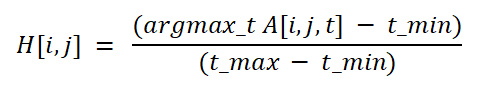
 2.	Canal de Saturation (S) :

 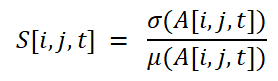
 3.	Canal de Luminosité (V) :

 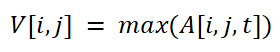

In [ ]:
def R_param(L):
  CV=np.sqrt((L * mt.gamma(L)**2/(mt.gamma(L+0.5)**2))-1);
  num=(L*mt.gamma(L)**4.*(4*(L**2)*mt.gamma(L)**2-4*L*mt.gamma(L+1/2)**2-mt.gamma(L+1/2)**2));
  den=(mt.gamma(L+1/2)**4.*(L*mt.gamma(L)**2-mt.gamma(L+1/2)**2));
  alpha=1/4*num/den;
  return(CV,alpha)

In [ ]:
def REACTIV(img,t, L = 1):
  (m,n,k) = img.shape

  tmin = np.min(t)
  tmax = np.max(t)

  H=np.zeros((m,n))
  argmax=np.argmax(img, axis = 2);
  for i in range(m):
    for j in range(n):
      H[i,j] = 0.9 * (t[argmax[i,j]] - tmin)/(tmax - tmin)

  print("H matrix calculated")

  threshold = np.mean(img[:,:,0])+3*np.std(img[:,:,0])
  V=(np.max(img, axis = 2)/threshold)
  V=(V<1)*V+(V>1)*1
  print("V matrix calculated")

  eps = 1e-16
  (CV,alpha) = R_param(L)
  S = np.std(img, axis = 2)/(np.mean(img, axis = 2) + eps)
  S=(S - CV)/(alpha/np.sqrt(k))/10.0+0.25

  S=(S>1)*1.+(S<1)*S
  S=(S>0)*S
  print("S matrix calculated")

  HSV=np.zeros([m,n,3])

  HSV[:, :, 0]=H
  HSV[:, :, 1]=S
  HSV[:, :, 2]=V

  return HSV

In [ ]:
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
def colar_bar(t):
  tmin = np.min(t)
  tmax = np.max(t)
  u = 0.9*(t - tmin)/(tmax - tmin)
  hsv_modified = get_cmap('hsv', 256)
  newcmp = ListedColormap(hsv_modified(u))
  return(newcmp)

In [ ]:
imch = color.hsv2rgb(REACTIV(im_abs_tsx_paris,t))

In [ ]:
from datetime import date
def visuchange(image,t):
  colors= np.linspace(0, len(t)-1, len(t))
  colorbar = np.transpose(np.vstack((colors, colors)))
  fig, ax = plt.subplots(1, 2, figsize=(12, 12),gridspec_kw={'width_ratios': [1, int(len(t)*1.8)]})
  ax[0].imshow(colorbar, cmap=colar_bar(t), aspect = 3)
  ax[0].get_xaxis().set_visible(False)
  ax[0].set_yticks(list(colors))
  ax[0].set_yticklabels([ date.fromordinal(d) for d in t])
  ax[1].imshow(image)
  ax[1].set_axis_off()

In [ ]:
visuchange(imch,t)

Resultats avec des images debruitées temporellement

In [ ]:
tden_imch=color.hsv2rgb(REACTIV(debruitees,t))

In [ ]:
visuchange(tden_imch,t)

Resultats avec des images debruitées spatialement

In [ ]:
m,n,k = im_abs_tsx_paris.shape
sp_deb = np.zeros((m,n,k))
for i in range(k):
  sp_deb[:,:,i] = lee_filter(im_abs_tsx_paris[:,:,i], window_size = 5)

In [ ]:
sden_imch=color.hsv2rgb(REACTIV(sp_deb,t))
visuchange(sden_imch,t)

Resultats avec des images debriotées temporellement et spatiallement

In [ ]:
m,n,k = im_abs_tsx_paris.shape
sp_tmp_deb = np.zeros((m,n,k))
for i in range(k):
  sp_tmp_deb[:,:,i] = lee_filter(debruitees[:,:,i], window_size = 5)

In [ ]:
sden_imch=color.hsv2rgb(REACTIV(sp_tmp_deb,t))
visuchange(sden_imch,t)

##Detection

In [ ]:
0.522723 * np.sqrt(2/np.pi)

In [ ]:
alpha = 0.01
img_detection = np.std(sp_tmp_deb, axis = 2)/np.mean(sp_tmp_deb,axis = 2)
seuil = np.quantile(img_detection.ravel(),1 - alpha)
change = (img_detection>seuil)

img_det= np.mean(sp_tmp_deb,axis = 2)

threshold = np.mean(img_det) + 3*np.std(img_det)

img_show = np.zeros((m,n,3))

image_sh = np.clip(img_det,0,threshold)
image_sh = image_sh/threshold
plt.figure(figsize=(12,12))
img_show[:,:,0] = np.clip(image_sh + change,0,1)
img_show[:,:,1] = image_sh * (1-change)
img_show[:,:,2] = image_sh* (1-change)
plt.imshow(img_show)

In [ ]:
m,n,k = im_abs_tsx_paris.shape
indexes = np.argmax(sp_tmp_deb, axis = 2)
img_sp_tp_mx  = np.zeros((m,n,k-1))

for i in range (m):
  for j in range(n):
    img_sp_tp_mx[i,j,:] = np.take(sp_tmp_deb[i,j,:],[u for u in range(k) if u != indexes[i,j]])

gamma_mx = np.std(img_sp_tp_mx, axis = 2)/np.mean(img_sp_tp_mx,axis = 2)

In [ ]:
m,n,k = im_abs_tsx_paris.shape
indexes = np.argmin(sp_tmp_deb, axis = 2)
img_sp_tp_mn  = np.zeros((m,n,k-1))

for i in range (m):
  for j in range(n):
    img_sp_tp_mn[i,j,:] = np.take(sp_tmp_deb[i,j,:],[u for u in range(k) if u != indexes[i,j]])

gamma_mn = np.std(img_sp_tp_mn, axis = 2)/np.mean(img_sp_tp_mn,axis = 2)

In [ ]:
f_gamma = gamma_mx/gamma_mn
alpha = 0.01
seuil = np.quantile(f_gamma.ravel(),1 - alpha)
change = (f_gamma >seuil)

img_det= np.mean(sp_tmp_deb,axis = 2)

threshold = np.mean(img_det) + 3*np.std(img_det)

img_show = np.zeros((m,n,3))

image_sh = np.clip(img_det,0,threshold)
image_sh = image_sh/threshold
plt.figure(figsize=(12,12))
img_show[:,:,0] = np.clip(image_sh + change,0,1)
img_show[:,:,1] = image_sh * (1-change)
img_show[:,:,2] = image_sh* (1-change)
plt.imshow(img_show)

##Resultat avec images SAR

In [ ]:
webpage='https://perso.telecom-paristech.fr/dalsasso/TPSAR/pilelely/multitemp/'
image='lely_tuple_multitemp.IMA'
im_lely_multitemp = mvalab.imz2mat(webpage+image)
im_lely_serie = np.abs(im_lely_multitemp[0]) # on ne s'intéresse qu'à l'amplitude

In [ ]:
m,n,k=im_lely_serie.shape # 25 images (dates), chacune de taille 512x512 pixels

In [ ]:
# analyse de l'histogramme de l'amplitude d'une image (première date)
plt.hist(im_lely_serie[:,:,0].ravel(),bins='auto',density=True,range=[0.,500])  # Rayleigh distributed
plt.title('histogram of amplitude')

In [ ]:
np.max(im_lely_serie[:,:,0])

In [ ]:
# si on affiche toute la dynamique, l'image apparaît peu contrastée et seulement quelques points ressortent (très forts rétrodiffuseurs)
plt.figure(figsize=(8,8))
plt.imshow((im_lely_serie[:,:,0]),cmap='gray')
plt.show()

In [ ]:
# on visualise la première (index 0) et la cinquème (index 4) date de la pile
visusar(im_lely_serie[:,:,0])
visusar(im_lely_serie[:,:,4])

In [ ]:
seuil = np.mean(im_lely_serie[:,:,0])+3*np.std(im_lely_serie[:,:,0])
visusar(im_lely_serie[:,:,0],seuil)
visusar(im_lely_serie[:,:,4],seuil)

In [ ]:
# analyse de l'histogramme de l'amplitude d'une image (première date)
plt.figure()
plt.hist(im_lely_serie[:,:,0].ravel(),bins='auto',density=True,range=[0.,1000])  # Rayleigh distributed
plt.title('histogram of amplitude')
plt.show()